<a href="https://colab.research.google.com/github/thad75/TP_ENSEA_ELEVE/blob/main/3A/SIA/TP2/Generative_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar xvzf ./maps.tar.gz
# !pip install pytorch-lightning


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(42)
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
import cv2 as cv
# from google.colab.patches import cv2_imshow
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.autograd import Variable
from pytorch_lightning import loggers as pl_loggers


## First we need the dataset

- to use it:
    - ***'path/to/train'*** or ***'path/to/test'***
    - a transformation pipeline

In [2]:
class GoogleDataset(Dataset):

  def __init__(self, path, transform = None):
    self.path = path
    self.images = [path + i for i in os.listdir(path)]
    self.transform = transform

  def __getitem__(self,idx):
    image = self.images[idx]
    full_image = cv2.imread(image)
    h, w, c = full_image.shape
    # split image and label following dataset format
    satellite = full_image[:, 0:int(w / 2), :]
    calque = full_image[:, int(w / 2):w, :]
    # debug_plot_separated_img_sample(satellite, calque) # debug to be sure both my pics are well separated
    
    if self.transform : 
      satellite = self.transform(satellite)
      calque = self.transform(calque)
    return {'satellite':satellite,
            'calque':calque}

  def __len__(self):
    return len(self.images)

## We then need the GENERATOR

- I already verified that it is powerful enough to capture the satelitte and calque image

In [4]:
import torch.nn as nn 
import torch

class ConvDown(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(ConvDown, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.model = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.out_channels,
                                            kernel_size = 3,
                                            stride = 1,
                                            padding = 0,
                                            dilation = 1),
                                  nn.BatchNorm2d(self.out_channels),
                                  nn.Dropout2d(0.5),
                                  nn.LeakyReLU(0.2))
  def forward(self,x):
      return self.model(x)

class ConvUp(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(ConvUp, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.model = nn.Sequential(nn.ConvTranspose2d(in_channels = self.in_channels,
                                      out_channels = self.out_channels,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 0,
                                      dilation = 1),
                                      nn.LeakyReLU(0.2))
  def forward(self,x):
      return self.model(x)

class Encoder(nn.Module):
  def __init__(self, in_channels, number_of_stack):
    super(Encoder, self).__init__()
    self.in_channels = in_channels
    self.number_of_stack = number_of_stack
    channels = [in_channels]+ [2**i for i in range(3,10)]
    self.encoder = nn.ModuleList([ConvDown(channels[i], channels[i+1]) for i in range(number_of_stack)])

  def forward(self, x):
    for i, layer in enumerate(self.encoder):
      x = layer(x)
    return x

class Decoder(nn.Module):
  def __init__(self, out_channels, number_of_stack):
    super(Decoder, self).__init__()
    channels = [out_channels]+ [2**i for i in range(3,10)]
    
    self.decoder = nn.ModuleList([ConvUp(channels[i+1], channels[i]) for i in range(number_of_stack)])[::-1]

  def forward(self, x):
    for i, layer in enumerate(self.decoder):
      x = layer(x)
    return x

class AutoEncoder(nn.Module):
  def __init__(self, in_channels, number_of_stack):
    super().__init__()
    self.in_channels = in_channels
    self.number_of_stack = number_of_stack
    self.encoder = Encoder(self.in_channels, number_of_stack) 
    self.decoder = Decoder(self.in_channels, number_of_stack)

  def forward(self, x):
    # TODO : Define your forward
    latent_representation = self.encoder(x)
    reconstructed_image = self.decoder(latent_representation)
    return reconstructed_image



In [7]:
# EXEMPLE : a model composed of 3 stacks
model = AutoEncoder(in_channels=3, number_of_stack=3) # in_channels=3 because input image is RGB, number_of_stack=3 because we want 3 DownConv and 3 UpConv

for name, param in model.named_parameters():
    print(name)

encoder.encoder.0.model.0.weight
encoder.encoder.0.model.0.bias
encoder.encoder.0.model.1.weight
encoder.encoder.0.model.1.bias
encoder.encoder.1.model.0.weight
encoder.encoder.1.model.0.bias
encoder.encoder.1.model.1.weight
encoder.encoder.1.model.1.bias
encoder.encoder.2.model.0.weight
encoder.encoder.2.model.0.bias
encoder.encoder.2.model.1.weight
encoder.encoder.2.model.1.bias
decoder.decoder.0.model.0.weight
decoder.decoder.0.model.0.bias
decoder.decoder.1.model.0.weight
decoder.decoder.1.model.0.bias
decoder.decoder.2.model.0.weight
decoder.decoder.2.model.0.bias


## And the DISCRIMINATOR

In [8]:
class DiscriConv(nn.Module):    
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.model = nn.Sequential(nn.Conv2d(in_channels = in_channels,
                                  out_channels = out_channels,
                                  kernel_size = kernel_size,
                                  stride = 2,
                                  padding = 1),
                                  nn.BatchNorm2d(out_channels),
                                  nn.LeakyReLU(0.2, inplace=True)
                                  )

       
  def forward(self,x):
      return self.model(x)

class Discriminator(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(DiscriConv(in_channels, 32,3),
                              DiscriConv(32, 64,4),
                              DiscriConv(64, 128,4),
                              # 128x4x4
                              nn.Conv2d(in_channels = 128,
                                        out_channels = out_channels,
                                        kernel_size = 3,
                                        bias=False),
                              nn.Sigmoid()
                              # NOTE it happen that it work better when predicting directly on convolution output 
                              # see how labels are generated in the training part
                              # nn.Flatten(start_dim=1, end_dim=-1), # TO OUTPUT ONLY 1 OR 0
                              # nn.Linear(588, 1)
                                        )
  def forward(self, x):
    return self.main(x)


### Now we want to check that every thing is instaniating well and work well:

- Is the Generator instanciate well ?
- does it work with the input picture ?
- does the generator output work with discriminator input ?

In [9]:
# we need our data loader:
transform =  transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((128, 128)),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                              ])

TRAIN_DATA_PATH = 'maps/train/' 
TEST_DATA_PATH = 'maps/val/'

train_data = GoogleDataset(TRAIN_DATA_PATH, transform=transform)
test_data = GoogleDataset(TEST_DATA_PATH, transform=transform)


train_data = DataLoader(train_data, batch_size = 1, shuffle=True)
test_data = DataLoader(test_data, batch_size = 1, shuffle=True)


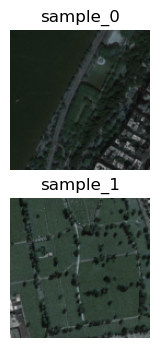

In [15]:
from utils import print_images

data_samples = []

# TO FIX
# you want at least two image in datasample or the print_image function will break
NSAMPLE = 1
for idx, batch in enumerate(train_data):
    data_samples.append((idx, batch['satellite']))
    if idx == NSAMPLE:
        break


print_images(data_samples, figsize=(2, 4))

#### Generator testing

- Note: See how augmenting the number of stack change the outputs, more you get to deep conv layer and more you loose information but better opportunity to learn deep features
- we dont need that for our task so we will keep the number of stack around 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input image shape: torch.Size([1, 3, 128, 128])
output image shape: torch.Size([1, 3, 128, 128])


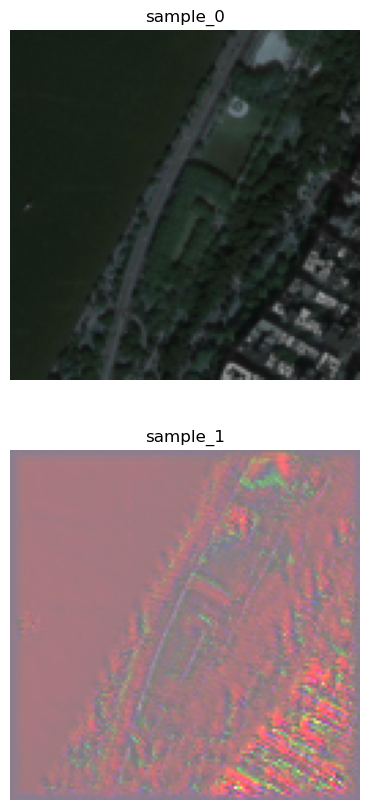

In [20]:
input_sample = data_samples[0][1]
gen_test = AutoEncoder(in_channels=3, number_of_stack=3)
print('input image shape:', input_sample.shape)

with torch.no_grad():
    generated_output = gen_test(input_sample)
print('output image shape:', generated_output.shape)

lst = [(0, input_sample), (1, generated_output)]

print_images(lst, figsize = (5, 10))

In [21]:
test_discriminator = Discriminator(3, 1)

with torch.no_grad():
    prediction = test_discriminator(generated_output)

print('prediction.shape:', prediction.shape)


prediction.shape: torch.Size([1, 1, 14, 14])


#### Everything seems to work pretty fine, lets gather all our paramters and try to train our model


In [22]:
if torch.backends.mps.is_available():
    print('running on device mps')
    device = torch.device('mps')
else:
    print('Warning: mps not available running on cpu')
    device = torch.device('cpu')

TRAIN_DATA_PATH = 'maps/train/' 
TEST_DATA_PATH = 'maps/val/'

data_transformation = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((256, 512)),
                                transforms.CenterCrop((256, 512)),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                ])
EPOCHS = 50
nbatch = 10
lr = 0.0001


train_data = GoogleDataset(TRAIN_DATA_PATH, transform=data_transformation)
test_data = GoogleDataset(TEST_DATA_PATH, transform=data_transformation)
train_data = DataLoader(train_data, batch_size = nbatch, shuffle=True)
test_data = DataLoader(test_data, batch_size = nbatch, shuffle=True)

criterion = nn.BCELoss()
criterionl1 = nn.L1Loss()

generator = AutoEncoder(in_channels = 3, number_of_stack = 5).to(device)

discriminator = Discriminator(in_channels = 6, out_channels = 3).to(device)

gen_opt = optim.Adam(generator.parameters(), lr=lr, betas=(0.005, 0.999))
discri_opt = optim.Adam(discriminator.parameters(), lr = lr, betas = (0.005, 0.999))

running on device mps


### Parameters Debug

In [23]:
#print(generator)
#for i, param in enumerate(generator.parameters()):
#    print(param.shape)
#    continue
#print(i)
#for j, param in enumerate(discriminator.parameters()):
#    print(param.shape)
#    continue
#print(j)

In [24]:
loss_trace = []
for epoch in range(EPOCHS):
    for idx, batch in enumerate(train_data):
        sat, cal = batch['satellite'].to(device), batch['calque'].to(device)

        # training the discriminator
        discri_opt.zero_grad()
        fake_img = generator(sat).detach()
        fake_sample = torch.cat([fake_img, cal], 1)
        fake_pred = discriminator(fake_sample)
        fake_labels = torch.zeros(fake_pred.shape, dtype=fake_pred.dtype).to(device)
        fake_loss = (criterion(fake_pred, fake_labels) * 0.5)

        true_sample = torch.cat([sat, cal], 1)
        true_pred = discriminator(true_sample)
        true_labels = torch.ones(true_pred.shape, dtype=true_pred.dtype).to(device)
        loss_true = (criterion(true_pred, true_labels) * 0.5)

        loss_full = loss_true + fake_loss
        loss_full.backward()
        discri_opt.step()

    # training the generator
        for i in range(2):
        # GENERATOR
            gen_opt.zero_grad()
            gen = generator(sat)
            generator_sample = torch.cat([gen, cal], 1)
            generator_pred = discriminator(generator_sample)
            gens_labels = torch.ones(generator_pred.shape, dtype=generator_pred.dtype).to(device)
            l1_gen_loss = criterionl1(gen, cal) * 100
            
            bce_gen_loss = criterion(generator_pred, gens_labels)
            gen_loss = l1_gen_loss + bce_gen_loss
            
            gen_loss.backward()
            gen_opt.step()

        if idx % 50 == 0:
            loss_trace.append({
                'discri_loss': fake_loss + loss_true,
                'gen_loss': gen_loss
            })
            print(f'epoch {epoch}/{EPOCHS}: batch {idx}/{len(train_data)} --> DISCRIMINATOR: {fake_loss + loss_true}  ----- GENERATOR: {gen_loss}\n----> l1: {l1_gen_loss} + bce: {bce_gen_loss}')

print('\n--->training is over')


epoch 0/50: batch 0/110 --> DISCRIMINATOR: 0.7088464498519897  ----- GENERATOR: 72.52330780029297
----> l1: 71.85612487792969 + bce: 0.6671861410140991
epoch 0/50: batch 50/110 --> DISCRIMINATOR: 0.40147665143013  ----- GENERATOR: 21.656679153442383
----> l1: 20.51240348815918 + bce: 1.1442756652832031
epoch 0/50: batch 100/110 --> DISCRIMINATOR: 0.16180671751499176  ----- GENERATOR: 24.08861541748047
----> l1: 22.227886199951172 + bce: 1.8607287406921387
epoch 1/50: batch 0/110 --> DISCRIMINATOR: 0.14021292328834534  ----- GENERATOR: 22.081233978271484
----> l1: 20.03386116027832 + bce: 2.0473735332489014
epoch 1/50: batch 50/110 --> DISCRIMINATOR: 0.07887706905603409  ----- GENERATOR: 21.161958694458008
----> l1: 18.579750061035156 + bce: 2.5822083950042725
epoch 1/50: batch 100/110 --> DISCRIMINATOR: 0.06511741876602173  ----- GENERATOR: 18.74024200439453
----> l1: 15.870916366577148 + bce: 2.8693246841430664
epoch 2/50: batch 0/110 --> DISCRIMINATOR: 0.0536152645945549  ----- GENER

In [368]:
with torch.no_grad():
    data_samples = []
    gens = []
    labels = []
    for idx, batch in enumerate(test_data):
        sat, calque = batch['satellite'].to(device), batch['calque'].to(device)
        
        data_samples.append( (idx, sat) )
        labels.append((idx, calque))
        gen_img = generator(sat)
        gens.append((idx, gen_img))
        if idx == 10:
            break

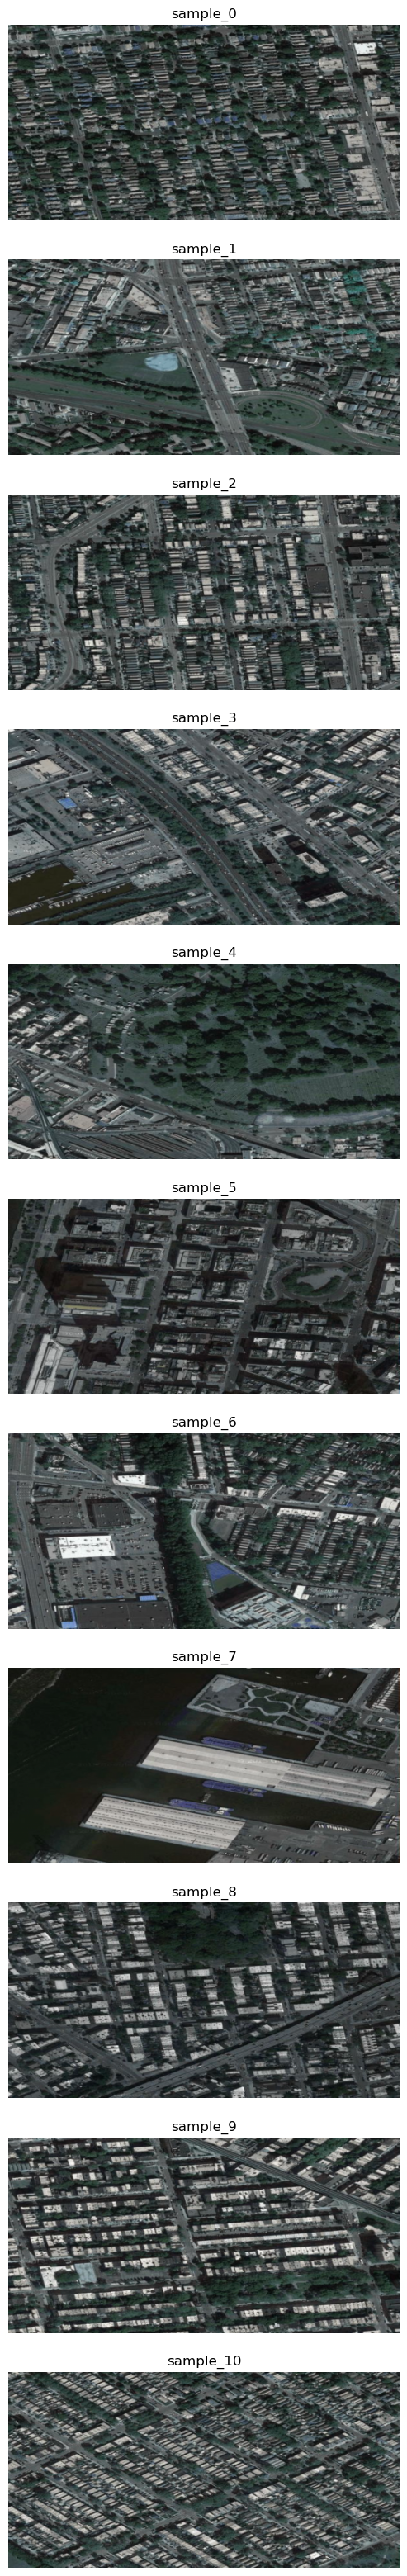

In [369]:
test = np.random.randint(0, 10)

# lst = [ data_samples[test], labels[test], gens[test] ]

print_images([(idx, tens.cpu()) for idx, tens in data_samples[:]], figsize = (30, 40))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

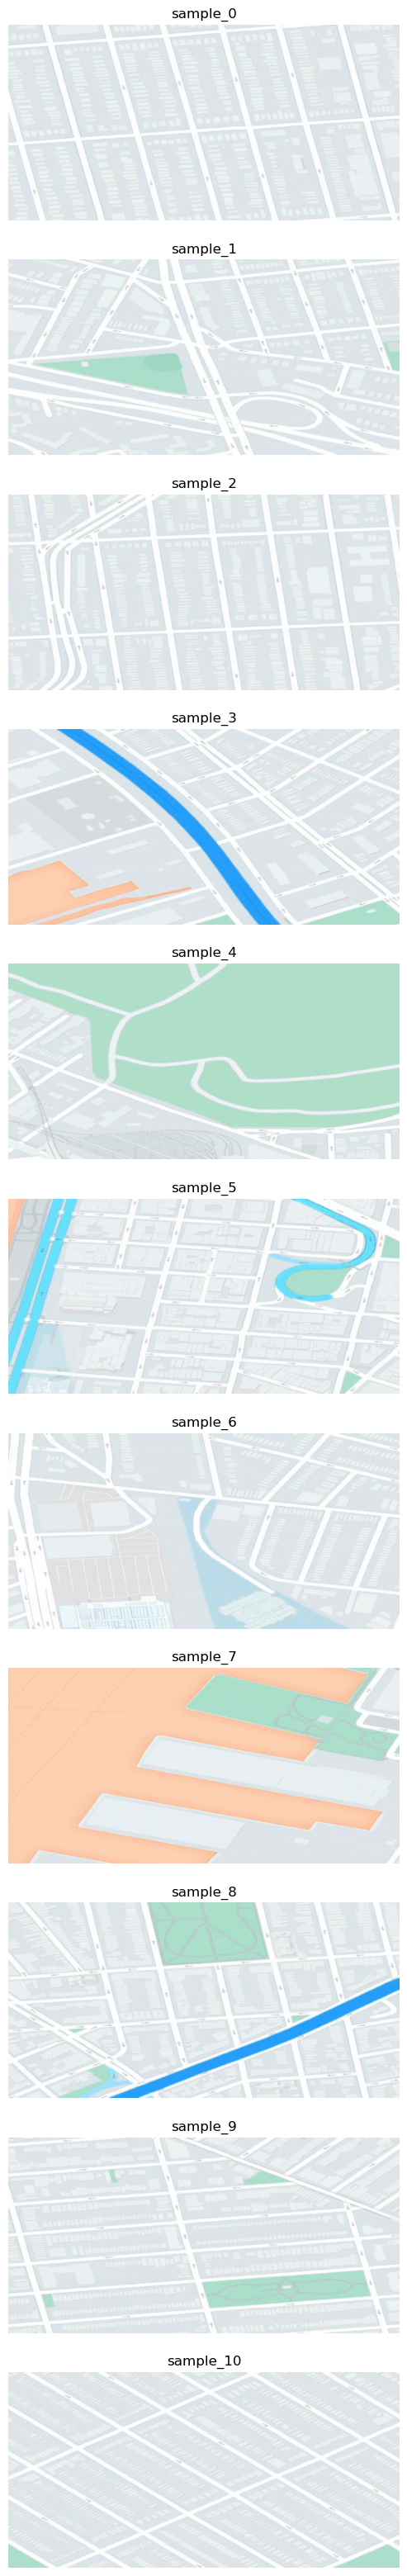

In [370]:
print_images([(idx, tens.cpu()) for idx, tens in labels[:]], figsize = (30, 40))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

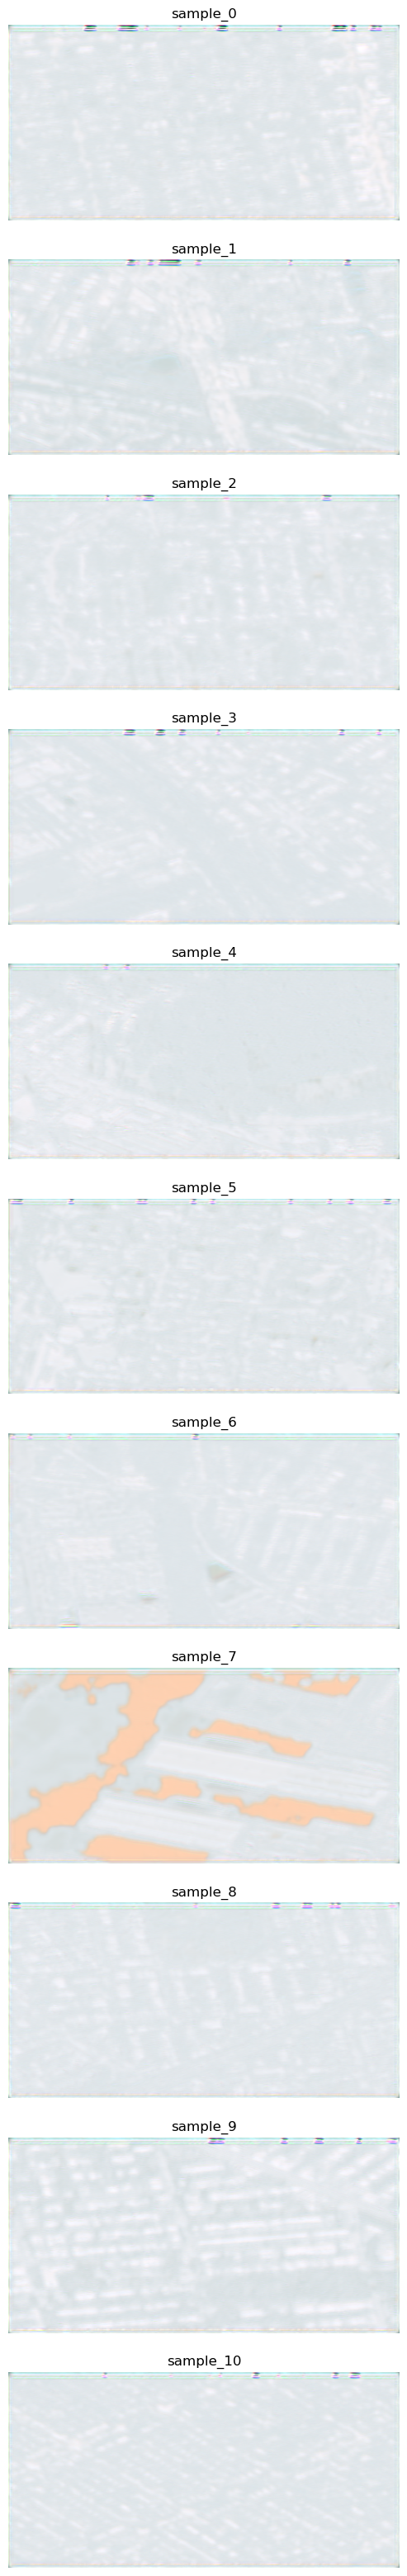

In [371]:
print_images([(idx, tens.cpu()) for idx, tens in gens[:]], figsize = (30, 40))
